In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time  # Importing the time module to calculate runtime


In [3]:

column_name='FIT201'
N=86400
L=2000


In [4]:
train_file_path="PASAD/Submission/DataFiles/SWaT_Dataset_Normal_v0.xlsx"
test_file_path="PASAD/Submission/DataFiles/SWaT_Dataset_Attack_v0.xlsx"


In [5]:

"""
Perform PASAD analysis using SSA and display scree plot, raw test data plot, and departure scores.

Parameters:
-----------
train_file_path : str
    Path to the CSV file containing the training dataset.
test_file_path : str
    Path to the CSV file containing the testing dataset.
column_name : str, optional
    The name of the column to use for the analysis (default is 'FIT601').
N : int, optional
    Number of samples for training from the end of the training data (default is 200000).
L : int, optional
    Lag parameter for trajectory matrix (default is 24).

Returns:
--------
None
"""



"\nPerform PASAD analysis using SSA and display scree plot, raw test data plot, and departure scores.\n\nParameters:\n-----------\ntrain_file_path : str\n    Path to the CSV file containing the training dataset.\ntest_file_path : str\n    Path to the CSV file containing the testing dataset.\ncolumn_name : str, optional\n    The name of the column to use for the analysis (default is 'FIT601').\nN : int, optional\n    Number of samples for training from the end of the training data (default is 200000).\nL : int, optional\n    Lag parameter for trajectory matrix (default is 24).\n\nReturns:\n--------\nNone\n"

In [6]:

# Load the training and testing datasets
train_data = pd.read_excel(train_file_path)
test_data = pd.read_excel(test_file_path)


In [7]:

# Extract the 'FIT601' column from both datasets and convert to numpy arrays
train_data = train_data[column_name].values[-N:]  # Use last N samples for training
test_data = test_data[column_name].values         # Use entire test data for detection


In [8]:

# Display basic information
print(f"Training data length: {len(train_data)}")
print(f"Testing data length: {len(test_data)}")


Training data length: 86400
Testing data length: 449919


In [9]:

# Create the trajectory matrix for training data
K = N - L + 1  # Number of lagged vectors
trajectory_matrix = np.zeros((L, K))

# Construct the lagged vectors for the trajectory matrix
for i in range(K):
    trajectory_matrix[:, i] = train_data[i:i + L]


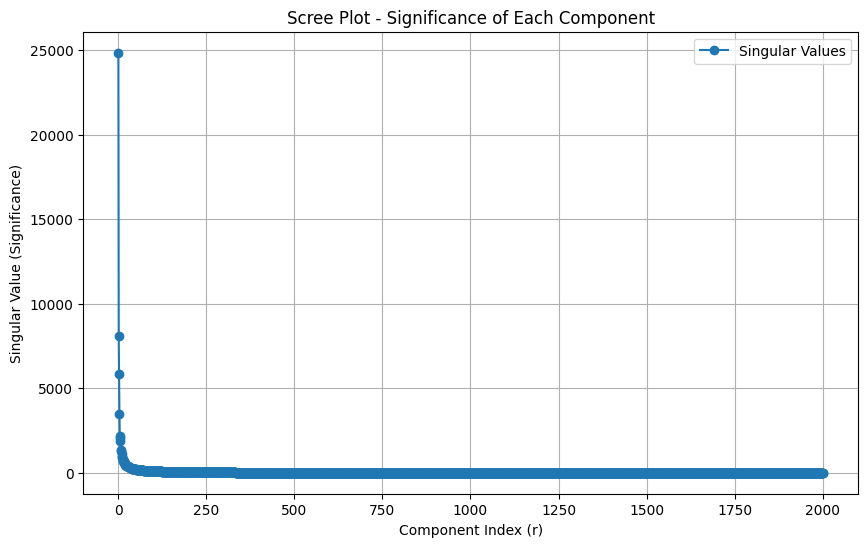

In [10]:

# Perform Singular Value Decomposition on the trajectory matrix
U, Sigma, VT = np.linalg.svd(trajectory_matrix, full_matrices=False)

# Plot the significance of each component (Scree plot)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(Sigma) + 1), Sigma, 'o-', label='Singular Values')
plt.title('Scree Plot - Significance of Each Component')
plt.xlabel('Component Index (r)')
plt.ylabel('Singular Value (Significance)')
plt.legend()
plt.grid(True)
plt.show()


In [11]:

# Select the top 'r' components based on singular values (choosing r=1 for simplicity)
r = 11
U_r = U[:, :r]


In [12]:

# Project the lagged training vectors onto the signal subspace
projected_train_vectors = U_r.T @ trajectory_matrix

# Compute the cluster_mean of the projected vectors
cluster_mean = np.mean(projected_train_vectors, axis=1)


In [13]:

# Function to calculate departure score for a new test vector
def compute_departure_score(test_vector, U_r, cluster_mean):
    # Project the test vector onto the signal subspace
    projected_test_vector = U_r.T @ test_vector
    # Compute the Euclidean distance from the cluster_mean
    departure_score = np.linalg.norm(projected_test_vector - cluster_mean)**2
    return departure_score


In [14]:

# Create test vectors and compute departure scores
test_departure_scores = []
for i in range(len(test_data) - L + 1):
    test_vector = test_data[i:i + L]
    score = compute_departure_score(test_vector, U_r, cluster_mean)
    test_departure_scores.append(score)

# Convert scores to a numpy array for easier plotting
test_departure_scores = np.array(test_departure_scores)

# Calculate the threshold for attack detection
threshold = np.mean(test_departure_scores) + 2 * np.std(test_departure_scores)


In [15]:

# Detect attack points: indices where departure scores exceed the threshold
attack_indices = np.where(test_departure_scores > threshold)[0]


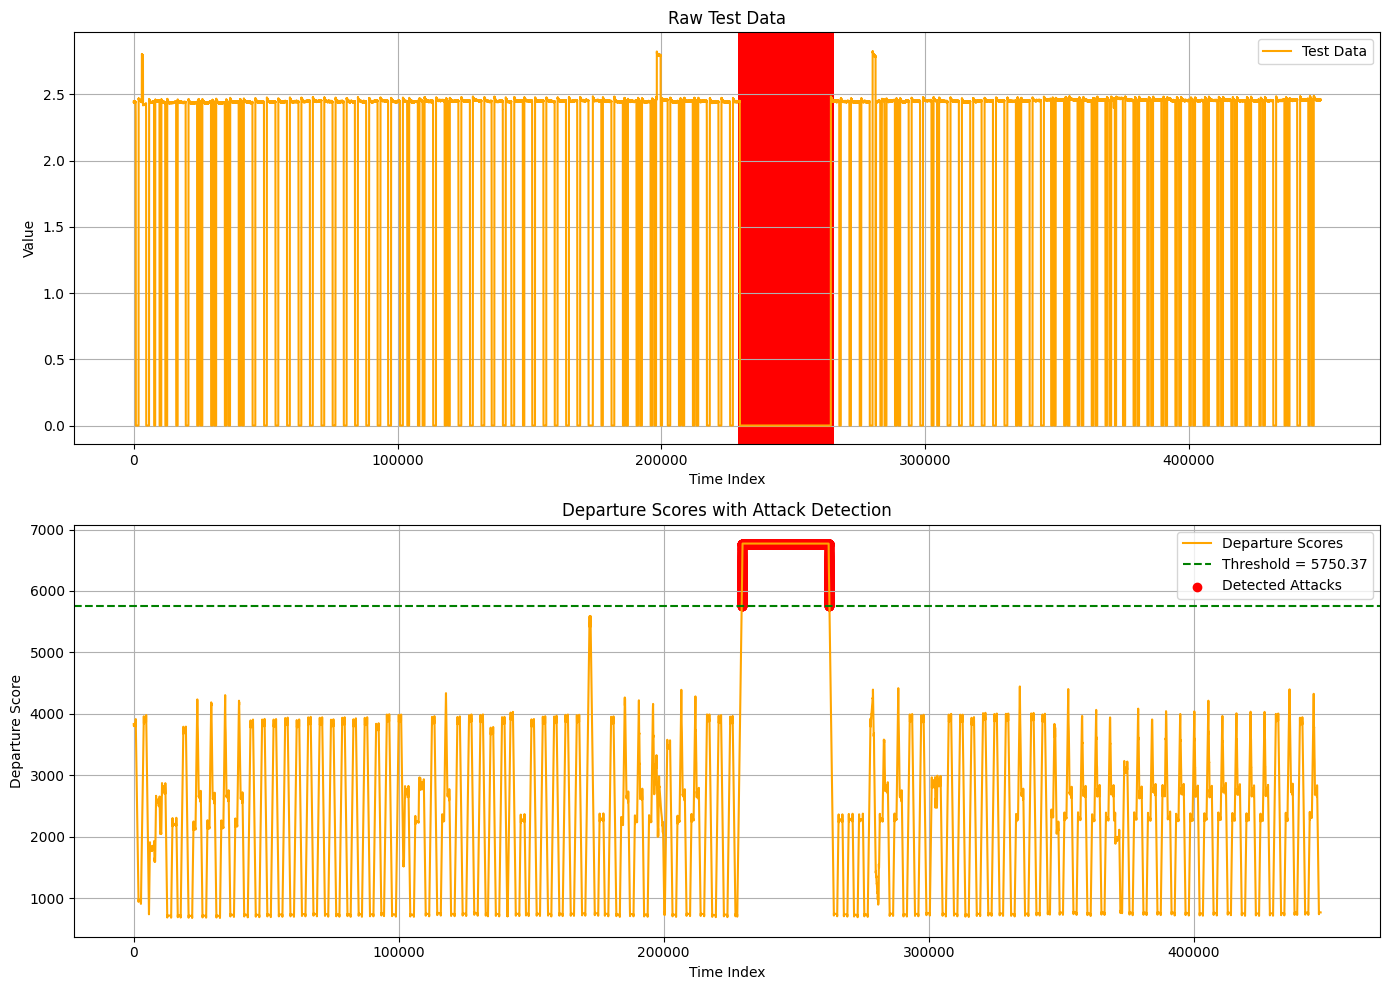

Attack detected at time indices (relative to test data): [229417 229418 229419 ... 262548 262549 262550]


In [17]:
# Create a figure with two subplots (2 rows, 1 column)
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Plot the raw test data on the first subplot (top)
ax[0].plot(test_data, label='Test Data', color='orange')
if len(attack_indices) > 0:
    for attack_start in attack_indices:
        ax[0].axvspan(attack_start, attack_start + L, color='red', alpha=0.3)
ax[0].set_title('Raw Test Data')
ax[0].set_xlabel('Time Index')
ax[0].set_ylabel('Value')
ax[0].legend()
ax[0].grid(True)

# Plot the departure scores on the second subplot (bottom)
ax[1].plot(test_departure_scores, label='Departure Scores', color='orange')
ax[1].axhline(y=threshold, color='green', linestyle='--', label=f'Threshold = {threshold:.2f}')
ax[1].scatter(attack_indices, test_departure_scores[attack_indices], color='red', label='Detected Attacks')
ax[1].set_title('Departure Scores with Attack Detection')
ax[1].set_xlabel('Time Index')
ax[1].set_ylabel('Departure Score')
ax[1].legend()
ax[1].grid(True)

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the combined figure with subplots in separate rows
plt.show()

# Print out the indices where attacks were detected
if len(attack_indices) > 0:
    print(f"Attack detected at time indices (relative to test data): {attack_indices}")
else:
    print("No attacks detected.")
